# Constructing an IMNN with on-the-fly additive noise

The IMNN is fairly flexible and extendable. As an example, lets imagine that we have some signal that we want to do inference on, but there is an expensive additive noise model which is can be simulated, but simulations on the fly would be extremely expensive. In this case we could make a set of different noises and save them to file (or in memory, etc.) and add them randomly to the signal. If the signal model is not differentiable then we would also have to use numerical derivatives to obtain the derivative of the network outputs with respect to the model parameters. This requires specific ordering of which noises are grabbed for a single iteration. 

This example will show how we can add a limited set of Gaussian noise on the fly to sloped lines, i.e.

$$y=mx+\epsilon$$

where our parameter of interest is a noisy slope, $m = m' + \zeta$ where $\zeta\leftarrow N(0, 0.1)$.

In [ ]:
from imnn import AggregatedNumericalGradientIMNN
from imnn.lfi import ApproximateBayesianComputation
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability
tfp = tensorflow_probability.substrates.jax
from functools import partial
from jax.experimental import stax
from jax.experimental import optimizers

In [ ]:
rng = jax.random.PRNGKey(0)

We will summarise the slope using `n_summaries=1` summaries and generate 2000 simulations and an extra 1000 simulations above and below the fiducial slope value to approximate the derivatives. For the fiducial value we'll choose $m'=1$ and $\delta m'=0.1$. We'll make $x$ a 100 length vector from 0 to 10. We'll make 500 noise realisations, $\epsilon$, drawn from a Gaussian with mean zero and variance 1.

In [3]:
n_params = 1
n_summaries = 1
input_shape = (100,)

n_s = 2000
n_d = 1000

n_noise = 500

m_fid = np.array([1.])
δm = np.array([0.1])

x = np.linspace(0, 10, input_shape[0])

The noises (which are not expensive in this case, but could be in general) are going to be drawn from a Gaussian, $ϵ\leftarrow N(0, 1)$

In [4]:
rng, key = jax.random.split(rng)
ϵ = jax.random.normal(key, shape=(n_noise,) + input_shape)

We'll also make the variable element of the simulation, $\zeta$ for training and validation.

In [5]:
rng, key, validation_key = jax.random.split(rng, num=3)
ζ = np.sqrt(0.1) * jax.random.normal(key, shape=(n_s,))
validation_ζ = np.sqrt(0.1) * jax.random.normal(validation_key, shape=(n_s,))

We can now make the datasets for the signal, i.e. $mx = (m^\textrm{fid} + \zeta)x$ and its derivatives $mx^{\pm}=(m^\textrm{fid}\pm\delta m/2 + \zeta)x$ for both the training and the validation

In [7]:
mx = np.expand_dims(m_fid[0] + ζ, 1) * np.expand_dims(x, 0)
mx_mp = np.expand_dims(
    np.stack(
        [(np.expand_dims((m_fid[0] - δm[0] / 2) + ζ[:n_d], 1) 
             * np.expand_dims(x, 0)),
         (np.expand_dims((m_fid[0] + δm[0] / 2) + ζ[:n_d], 1) 
             * np.expand_dims(x, 0))],
        1),
    2)

validation_mx = (np.expand_dims(m_fid[0] + validation_ζ, 1) 
    * np.expand_dims(x, 0))
validation_mx_mp = np.expand_dims(
    np.stack(
        [(np.expand_dims((m_fid[0] - δm[0] / 2) + validation_ζ[:n_d], 1) 
              * np.expand_dims(x, 0)),
         (np.expand_dims((m_fid[0] + δm[0] / 2) + validation_ζ[:n_d], 1) 
              * np.expand_dims(x, 0))],
        1),
    2)

### Constructing a new IMNN

Now we can construct the new IMNN. For our example we'll imagine that we want to use the AggregatedNumericalGradientIMNN (normally used for large datasets where the derivative of the simulations with respect to the model parameters can not easily be calculated). In this case we can use AggregatedNumericalGradientIMNN as the parent class, and initialise all attributes and add just the noise as an input (from which we will get the number of noises available from its shape). Now we just need to edit two of the class functions to add random noises on the fly. First the generators provided in `_collect_input` needs to be editted to output a random key as well as the dataset. Aggregation is quite fiddly in the IMNN due to the need to properly slice the data - the fiducial datasets are transformed into a numpy iterator via a TensorFlow dataset, we need to therefore augment the normal dataset to return a key as well. For every XLA device used for aggregation then there is a separate dataset with `n_s // (n_devices * n_per_device)` yields with `n_per_device` elements. Our generator therefore must iterate through the dataset and return corresponding keys before resetting. To do this we will generate `n_s` keys and define a generator which takes in this list of keys and the dataset and yield the next iteration of data and the `i`th iteration of keys (which resets after `n_s // (n_devices * n_per_device)` iterations). This is true for the fiducial dataset, but the derivative dataset needs repeated keys for every parameter direction used for the numerical derivative. For this `n_d` of the keys are repeated `2 * n_params` times before being reshaped and returned by the same generator. With these generators made we now just need to change the `fn` function of `get_summary` such that it splits apart the signal data (called `d`) from the key, and we then use the key to grab a random integer between 0 and the amount of noise passed to the class and use that integer to get noise which is then added to the signal before the input to the neural network. Because of the way the generators are constructed for the derivative dataset the same noise will be added to each set of simulations for a single derivative.

In [8]:
class NoiseIMNN(AggregatedNumericalGradientIMNN):
    def __init__(self, noise, **kwargs):
        super().__init__(**kwargs)
        self.noise = noise
        self.n_noise = self.noise.shape[0]
    
    def get_summary(self, inputs, w, θ, derivative=False, gradient=False):
        def fn(inputs, w):
            d, key = inputs
            ϵ = self.noise[jax.random.randint(key, (), minval=0, maxval=self.n_noise)]
            return self.model(w, d + ϵ)
        if gradient:
            dΛ_dx, d = inputs
            dx_dw = jax.jacrev(fn, argnums=1)(d, w)
            return self._construct_gradient(dx_dw, aux=dΛ_dx, func="einsum")
        else:
            return fn(inputs, w)

    def _collect_input(self, key, validate=False):
        def generator(dataset=None, key=None, total=None):
            i = 0
            while i < total:
                yield next(dataset), key[i]
                i += 1
            i = 0
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
        keys = np.array(jax.random.split(key, num=self.n_s))
        return (
            [partial(generator, dataset=fid, key=key, total=key.shape[0])() 
             for fid, key in zip(fiducial, keys.reshape(self.fiducial_batch_shape + (2,)))],
            [partial(generator, dataset=der, key=key, total=key.shape[0])() 
             for der, key in zip(derivative, np.repeat(keys[:n_d], 2 * self.n_params, axis=0).reshape(
                 self.derivative_batch_shape + (2,)))])

We're going to use jax's stax module to build a simple network with three hidden layers each with 128 neurons and which are activated by leaky relu before outputting the two summaries. The optimiser will be a jax Adam optimiser with a step size of 0.001.

In [9]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries),
)
optimiser = optimizers.adam(step_size=1e-3)

The NoiseIMNN can now be initialised setting up the network and the fitting routine (as well as the plotting function), where we will use the CPU as the host device and use the GPUs for calculating the summaries and say that we know that we can process 100 simulations at a time per device before running out of memory.

In [10]:
rng, key = jax.random.split(rng)
imnn = NoiseIMNN(
    noise=ϵ, 
    n_s=n_s, 
    n_d=n_d, 
    n_params=n_params,
    n_summaries=n_summaries,
    input_shape=input_shape,
    θ_fid=m_fid,
    model=model,
    optimiser=optimiser,
    key_or_state=key,
    fiducial=mx,
    derivative=mx_mp, 
    δθ=δm,
    host=jax.devices("cpu")[0], 
    devices=jax.devices(), 
    n_per_device=100, 
    validation_fiducial=validation_mx,
    validation_derivative=validation_mx_mp)

To set the scale of the regularisation we use a coupling strength  𝜆  whose value should mean that the determinant of the difference between the covariance of network outputs and the identity matrix is larger than the expected initial value of the determinant of the Fisher information matrix from the network. How close to the identity matrix the covariance should be is set by  𝜖 . These parameters should not be very important, but they will help with convergence time. Fitting can then be done simply by calling:

In [11]:
rng, key = jax.random.split(rng)
imnn.fit(λ=10., ϵ=0.1, rng=key, print_rate=1)

0it [00:00, ?it/s]

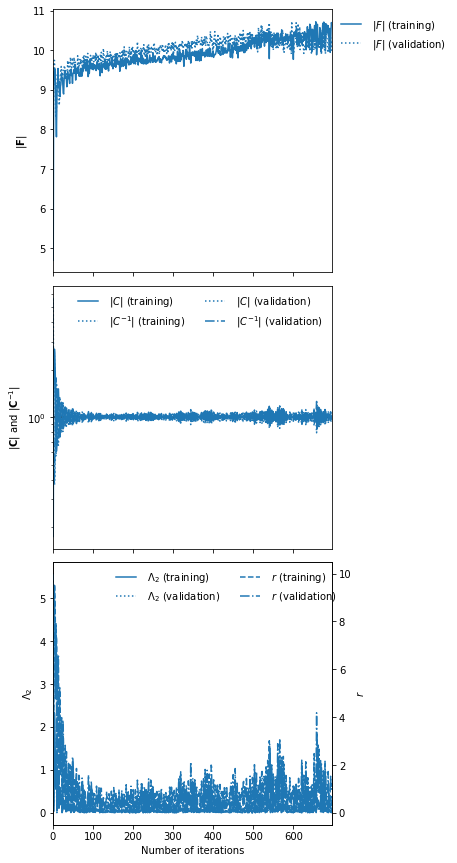

In [12]:
imnn.plot();

## Inference

Now lets say we want to infer the slope of some data we can use this trained IMNN and the ABC module (with some premade simulations). I'm going to first generate some data to infer:

In [13]:
rng, key = jax.random.split(rng)

target_m = 3.
y_target = (target_m * x + np.sqrt(0.1) 
            * jax.random.normal(key, shape=input_shape))

We'll make a bunch of new simulations for the ABC too. First we'll draw many (5000) different values of slopes and calculate $mx$ for each of these slopes. Then we'll sum all of the expensive noise realisations to every example to get 2500000 different realisations of noise and signal. We'll compress all of these using the IMNN and also repeat the parameter values used to make these simulations (because there are now 500 examples of each parameter due to the noise realisations).

In [55]:
rng, key = jax.random.split(rng)

m_ABC = np.expand_dims(
    jax.random.uniform(
        key, minval=0., maxval=10., shape=(5000,)),
    1)
y_ABC = np.einsum(
    "ij,kj->ikj", 
    m_ABC * x, 
    ϵ).reshape((-1,) + input_shape)

parameters = np.repeat(m_ABC, n_noise, axis=0)
summaries = imnn.get_estimate(y_ABC)

We'll use TensorFlow Probability to define a prior distribution between zero and 10 for the slope

In [57]:
prior = tfp.distributions.Independent(
    tfp.distributions.Uniform(low=[0.], high=[10.]),
    reinterpreted_batch_ndims=1)
prior.low = np.array([0.])
prior.high = np.array([10.])

We'll then initialise the ApproximateBayesianComputation module using the IMNN as the compression function for `y_target`

In [72]:
ABC = ApproximateBayesianComputation(
    target_data=y_target, 
    prior=prior, 
    simulator=None, 
    compressor=imnn.get_estimate,
    gridsize=100, 
    F=imnn.F)

We can then run the ABC with an $\epsilon=0.1$ with the compressed examples with corresponding parameter values

In [73]:
ABC(ϵ=0.1, parameters=parameters, summaries=summaries);

Plotting the accepted parameters gives us the posterior distribution of the value of possible slopes. We can also plot the value of the slope used to generate the target data for completeness.

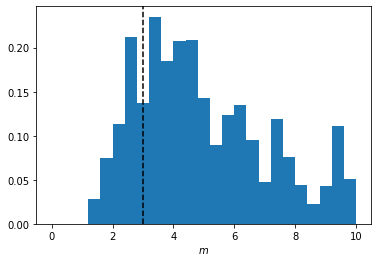

In [80]:
plt.hist(ABC.parameters.accepted[0][:, 0], 
         range=[0, 10], 
         bins=25,
         density=True)
plt.axvline(target_m, linestyle="dashed", color="black")
plt.xlabel(r"$m$");